# 🦁 Animal Image Classification (90 Classes) using Deep Learning

## 1. Definisi Masalah
Tujuan dari proyek ini adalah membangun model Deep Learning yang mampu mengklasifikasikan gambar hewan ke dalam **90 kategori spesies** yang berbeda.

Dataset yang digunakan berasal dari Kaggle: *Animal Image Dataset (90 Different Animals)*.
Tantangan utama dalam proyek ini adalah banyaknya jumlah kelas (90 classes), yang meningkatkan risiko model menjadi bingung antar spesies yang mirip. Oleh karena itu, kita akan menggunakan pendekatan **Transfer Learning** untuk mendapatkan ekstraksi fitur yang optimal.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Konfigurasi GPU (Opsional, jika punya GPU NVIDIA)
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## 2. Pengumpulan & Persiapan Data
Kita akan memuat data gambar dan membaginya menjadi set **Training** (untuk melatih model) dan **Validation** (untuk mengukur performa saat pelatihan agar tidak overfitting).

Kita menggunakan `ImageDataGenerator` untuk melakukan normalisasi piksel (rescaling) secara otomatis.

In [2]:
# Path dataset (sesuaikan dengan nama folder hasil ekstrak kamu)
dataset_path = 'animals/animals'

# Parameter
IMG_SIZE = (224, 224) # Ukuran standar MobileNetV2
BATCH_SIZE = 32

# Membuat Generator Data dengan Validasi Split 20%
datagen = ImageDataGenerator(
    rescale=1./255,       # Normalisasi nilai piksel ke 0-1
    validation_split=0.2  # 20% data untuk validasi
)

# Load Training Data
train_ds = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load Validation Data
val_ds = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Menyimpan nama kelas
class_names = list(train_ds.class_indices.keys())
print(f"Jumlah Kelas: {len(class_names)}")
print(f"Contoh Kelas: {class_names[:5]}")

Found 4320 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.
Jumlah Kelas: 90
Contoh Kelas: ['antelope', 'badger', 'bat', 'bear', 'bee']


## 3. Exploratory Data Analysis (EDA)
Sebelum melatih model, sangat penting untuk melihat sampel data dan distribusi kelas untuk memastikan dataset seimbang.

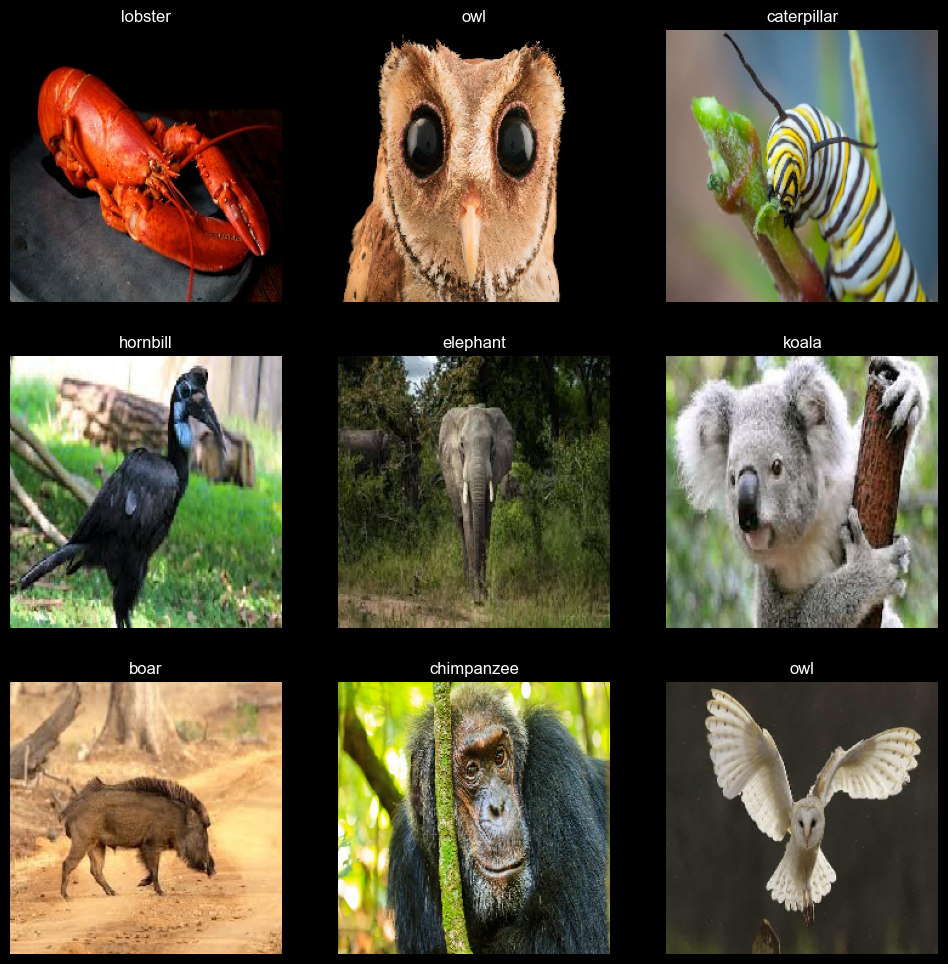

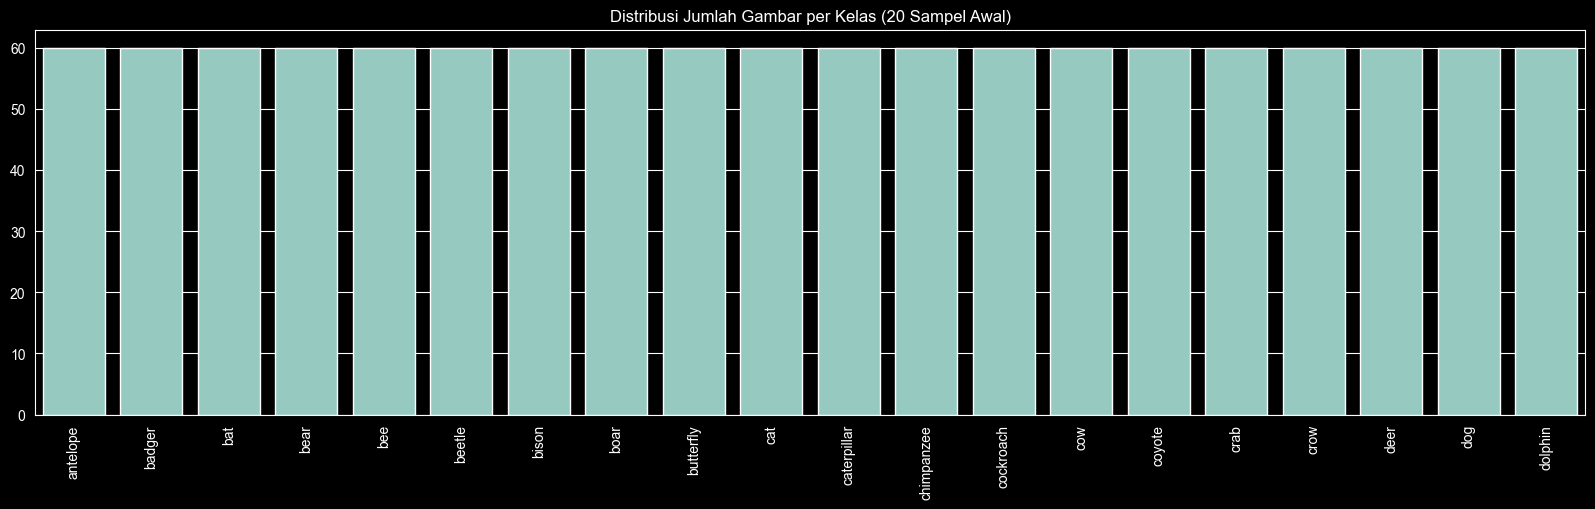

In [3]:
# 1. Visualisasi Sampel Gambar
plt.figure(figsize=(12, 12))
# Mengambil satu batch gambar
imgs, labels = next(train_ds)

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i])
    # Mengambil nama kelas dari one-hot encoding
    label_index = np.argmax(labels[i])
    plt.title(class_names[label_index])
    plt.axis("off")
plt.show()

# 2. Cek Distribusi Kelas (Opsional - butuh waktu scanning file)
# Disarankan hanya menampilkan jumlah file per folder jika dataset sangat besar
folder_counts = []
for folder in os.listdir(dataset_path):
    folder_counts.append(len(os.listdir(os.path.join(dataset_path, folder))))

plt.figure(figsize=(20, 5))
sns.barplot(x=class_names[:20], y=folder_counts[:20]) # Menampilkan 20 kelas pertama saja agar rapi
plt.xticks(rotation=90)
plt.title("Distribusi Jumlah Gambar per Kelas (20 Sampel Awal)")
plt.show()

## 4. Membangun Model (Transfer Learning)
Karena kita memiliki 90 kelas dan dataset yang terbatas, melatih CNN dari awal (scratch) akan sulit mencapai akurasi tinggi.
Kita akan menggunakan **MobileNetV2** yang sudah dilatih sebelumnya (*pre-trained*) pada dataset ImageNet.



**Strategi:**
1.  **Base Model:** MobileNetV2 (tanpa lapisan klasifikasi atas/top). Layer ini akan dibekukan (*frozen*) agar bobotnya tidak rusak saat pelatihan awal.
2.  **Custom Head:** Kita menambahkan lapisan *GlobalAveragePooling*, *Dropout* (untuk mencegah overfitting), dan *Dense Output* dengan 90 neuron (Softmax).

In [4]:
# Load Pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Membangun arsitektur kustom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) # Mencegah overfitting
predictions = Dense(90, activation='softmax')(x) # 90 neuron untuk 90 kelas

model = Model(inputs=base_model.input, outputs=predictions)

# Kompilasi Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,433,562 (9.28 MB)

 Trainable params: 175,578 (685.85 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 5. Pelatihan Model (Model Training)
Kita akan melatih model dengan callback **EarlyStopping** agar pelatihan berhenti otomatis jika akurasi validasi tidak bertambah, sehingga menghemat waktu.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=100, # Bisa dinaikkan jika akurasi belum maksimal
    validation_data=val_ds,
    callbacks=[early_stop]
)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.0255 - loss: 4.5290 - val_accuracy: 0.0861 - val_loss: 4.2359
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.0840 - loss: 4.1221 - val_accuracy: 0.2704 - val_loss: 3.8171
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.1898 - loss: 3.6516 - val_accuracy: 0.4657 - val_loss: 3.2278
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.3157 - loss: 3.1433 - val_accuracy: 0.5694 - val_loss: 2.6502
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 654s 5s/step - accuracy: 0.4081 - loss: 2.6909 - val_accuracy: 0.6463 - val_loss: 2.1862
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.4898 - loss: 2.3051 - val_accuracy: 0.6935 - val_loss: 1.8350
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.5502 - loss: 2.0062 - val_accuracy: 0.7222 - val_loss: 1.5897
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.6035 - loss: 1.7603 - 

## 6. Evaluasi Model
Mengevaluasi performa model menggunakan grafik Loss dan Accuracy, serta Classification Report.

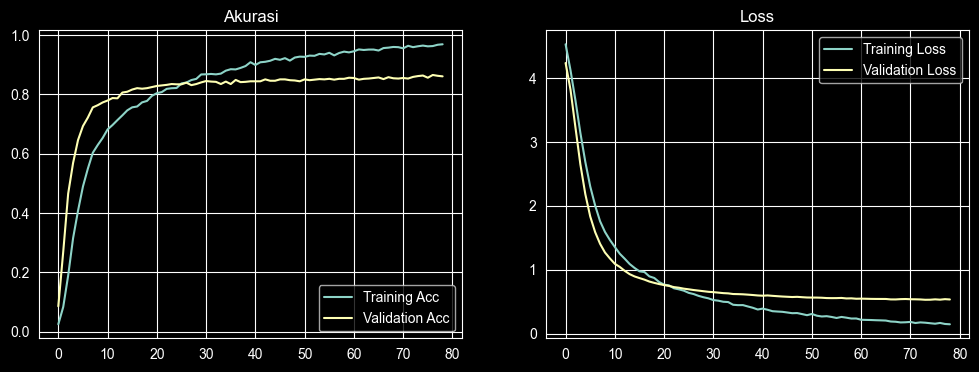

In [6]:
# Plot Akurasi dan Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.legend()
plt.title('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

## 7. Menyimpan Model
Menyimpan model yang sudah dilatih agar bisa digunakan untuk deployment menggunakan Streamlit.

In [8]:
model.save('animal_model_90classes.keras')
print("Model berhasil disimpan!")

# Menyimpan label mapping agar di streamlit bisa membaca nama hewan
import json
class_indices = train_ds.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

Model berhasil disimpan!
